In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def poisson_random_process(lmbda, total_time):
    """
    Generate a Poisson random process.
    
    Parameters:
        lmbda (float): The parameter lambda of the Poisson distribution.
        total_time (float): The total time for the process.
    
    Returns:
        numpy.ndarray: An array of timestamps when events occur.
    """
    num_events = np.random.poisson(lmbda * total_time)
    event_times = np.cumsum(np.random.exponential(1 / lmbda, num_events))
    event_times = event_times[event_times < total_time]
    return event_times



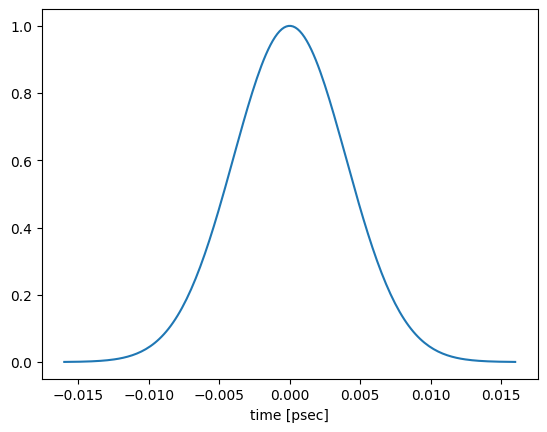

In [3]:
## HOM for partially distinguishable photons
hom_coincidence = lambda x, dw: np.exp(-(x*dw) **2/2 ) 
dw = 250 # GHz
x = np.linspace(-1,1,200)*4/dw
plt.plot(x, hom_coincidence(x,dw))
plt.xlabel("time [psec]")
plt.show()

## baseline

In [5]:
gen_rate = 1e5 # Parameter lambda in Hz
total_time = 1e-3  # Total time in sec for the process
linewidth_list = 10** np.arange(3,7.1)
# tolerance_list = np.arange(.2,1.1,.2)*1e-9 

Nrep = 1000
succ_rate = np.zeros((len(linewidth_list), Nrep))
for i_w, dw in enumerate(linewidth_list):
    print(i_w, end="\r")
    tic = time.time()
    for i_r in range(Nrep):
        # print(i_r, end="\r")
        s1 = poisson_random_process(gen_rate, total_time)
        s2 = poisson_random_process(gen_rate, total_time)

        num_trials = min(s1.shape[0],s2.shape[0])
        # num_trials
        all_events = np.concatenate((s1,s2))
        events_inds = all_events.argsort()
        all_events = all_events[events_inds]
        emissions = np.zeros(events_inds.shape[0])
        emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

        time_diff = []

        i1 = 0
        photon1 = emissions[i1]
        # coincident_counter = 0
        for i_trial in range(num_trials):
            next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
            if len(next_event)>0:
                i2 = i1+ next_event[0,0] +1 
                photon2 = emissions[i2]
                dt = all_events[i2]-all_events[i2-1]
                time_diff.append(dt)
                assert dt>0

                i1 = i2 + 1
                if i1 < len(emissions):
                    photon1 = emissions[i1]
                else:
                    break
            else:
                break
            
        time_diff = np.array(time_diff)
        # accepted_ids = np.argwhere(time_diff< tolerance)[:,0]
        succ_rate[i_w,i_r] = np.mean(hom_coincidence(time_diff,dw))/total_time

    toc = time.time()
    print(f"{i_w}, elapsed time {toc-tic} sec")



0, elapsed time 0.5369822978973389 sec
1, elapsed time 0.5322086811065674 sec
2, elapsed time 0.5299525260925293 sec
3, elapsed time 0.5302677154541016 sec
4, elapsed time 0.5341274738311768 sec


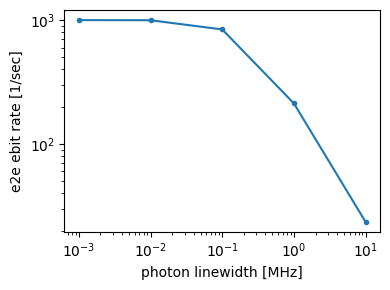

In [6]:
plt.figure(figsize=(4,3))
plt.plot(linewidth_list/1e6, (succ_rate).mean(axis=1), ".-")#, color = f"C{i_t}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"photon linewidth [MHz]")
plt.ylabel("e2e ebit rate [1/sec]")
# plt.ylim([3e1,1e6])
# plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_zoomed.pdf")
plt.show()


In [31]:
fname = f"results/rates_vs_linewidth.npz"
np.savez(fname,gen_rate, total_time,
         linewidth_list,
         succ_rate)

# Success probability per time slot

In [8]:

gen_rate = 1e6 # Parameter lambda in Hz
total_time_list = np.logspace(-5,-2,10)  # Total time in sec for the process
# linewidth_list = 10** np.arange(9,12)
linewidth_list = 10** np.arange(9,9.1)

Nrep = 1000
succ_prob = np.zeros((len(total_time_list),len(linewidth_list), Nrep))
for i_t, total_time in enumerate(total_time_list):
    tic = time.time()
    print(i_t, end="\r")
    for i_w, dw in enumerate(linewidth_list):
        for i_r in range(Nrep):
            # print(i_r, end="\r")
            s1 = poisson_random_process(gen_rate, total_time)
            s2 = poisson_random_process(gen_rate, total_time)

            num_trials = min(s1.shape[0],s2.shape[0])
            # num_trials
            all_events = np.concatenate((s1,s2))
            events_inds = all_events.argsort()
            all_events = all_events[events_inds]
            emissions = np.zeros(events_inds.shape[0])
            emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

            i1 = 0
            # photon1 = emissions[i1]
            # coincident_counter = 0
            # for i_trial in range(num_trials):
            while i1 < len(emissions):
                photon1 = emissions[i1]
                next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                if len(next_event)>0:
                    i2 = i1+ next_event[0,0] +1 
                    photon2 = emissions[i2]
                    dt = all_events[i2]-all_events[i2-1]
                    assert dt>0

                    prob = 0.5* hom_coincidence(dt,dw) # 0.5 for BSM post selection
                    if np.random.rand()< prob: # accept with probability p
                        succ_prob[i_t,i_w,i_r] += 1
                        break 

                    i1 = i2 + 1
                    # if i1 < len(emissions):
                    # photon1 = emissions[i1]
                    # else:
                    #     break
                else:
                    break
                    
    toc = time.time()
    print(f"({i_t}), elapsed time {toc-tic} sec")

# print(trans_prob.mean(axis=2))

(0), elapsed time 0.09775328636169434 sec
(1), elapsed time 0.163496732711792 sec
(2), elapsed time 0.31856679916381836 sec
(3), elapsed time 0.6708834171295166 sec
(4), elapsed time 1.4134695529937744 sec
(5), elapsed time 2.9478092193603516 sec
(6), elapsed time 5.727404356002808 sec
(7), elapsed time 10.261982202529907 sec
(8), elapsed time 23.653552055358887 sec
(9), elapsed time 51.31159281730652 sec


In [4]:
fname = f"results/prob_vs_timeslot_hom_dense.npz"
np.savez(fname,gen_rate, total_time_list,
         linewidth_list,
         succ_prob)

NameError: name 'gen_rate' is not defined

In [5]:
fname = f"results/prob_vs_timeslot_hom_dense.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time_list = f1['arr_1'] 
linewidth_list =  f1['arr_2'] 
succ_prob = f1['arr_3'] 



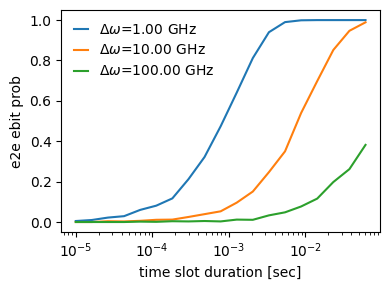

In [6]:
plt.figure(figsize=(4,3))
for i_w, dw in enumerate(linewidth_list):
    plt.plot(total_time_list, (succ_prob[:,i_w,:]).mean(axis=-1), "-",markersize=2, color = f"C{i_w}", label=fr"$\Delta\omega$={dw/1e9:.2f} GHz")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"time slot duration [sec]")
plt.ylabel("e2e ebit prob")
# plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_baseline.pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()
